1. Change the structure to be identical to Goodfellow's Figure 10.3 with tanh activation functions and see if you get different results.

In [1]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        # A bit more efficient than normal Softmax
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        a = self.i2h(combined)
        hidden = torch.tanh(a)
        o = self.h2o(hidden)
        y_hat = self.softmax(o)
        # hidden = self.i2h(combined)
        # output = self.i2o(combined)
        # output = self.softmax(output)
        return y_hat, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch


# Util Functions
def findFiles(path):
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def letterToIndex(letter):
    return all_letters.find(letter)

# (For demonstration) turn a letter into a <1 x n_letters> tensor

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# (an array of one-hot letter vectors)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i




# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


# Prepare Data
all_letters = string.ascii_letters + " .,;'"

category_lines = {}
all_categories = []

n_letters = len(all_letters)

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines


n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [3]:

import random

def randomChoice(l):
    # random.randint range is inclusive thus len(l)-1
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

# for i in range(10):
#     category, line, category_tensor, line_tensor = randomTrainingExample()
#     print('category =', category, '/ line =', line)

# If use softmax -> corss entropy
# If use logsoftmax -> negative log likelihood loss
criterion = nn.NLLLoss()

In [4]:
input = letterToTensor('B')
hidden = torch.zeros(1, n_hidden)
print(input)
output, next_hidden = rnn(input, hidden)
output

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


tensor([[-2.8661, -3.0345, -2.7974, -2.8919, -2.7731, -2.8110, -2.8196, -2.9037,
         -2.8594, -3.0084, -2.9827, -2.7890, -3.0119, -2.8837, -2.8967, -2.9485,
         -2.8378, -2.9689]], grad_fn=<LogSoftmaxBackward>)

In [5]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [6]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 2.7034 Finke / French ✗ (Czech)
10000 10% (0m 9s) 1.7379 Duncan / Irish ✗ (Scottish)
15000 15% (0m 14s) 1.6726 Acker / Dutch ✗ (German)
20000 20% (0m 19s) 0.8309 Modugno / Italian ✓
25000 25% (0m 24s) 0.7294 Sullivan / Irish ✓
30000 30% (0m 28s) 3.6543 Ogterop / French ✗ (Dutch)
35000 35% (0m 33s) 2.7841 Kromberg / Scottish ✗ (English)
40000 40% (0m 38s) 1.7901 Magalhaes / Greek ✗ (Portuguese)
45000 45% (0m 43s) 0.7317 O'Halloran / Irish ✓
50000 50% (0m 48s) 1.2047 Chu / Korean ✗ (Vietnamese)
55000 55% (0m 53s) 0.6923 Hrabak / Czech ✓
60000 60% (0m 57s) 0.1074 Ferreiro / Portuguese ✓
65000 65% (1m 2s) 0.6047 Vo / Vietnamese ✓
70000 70% (1m 7s) 0.9486 Salazar / Portuguese ✓
75000 75% (1m 12s) 2.7115 Theohari / Japanese ✗ (Greek)
80000 80% (1m 16s) 3.1552 Bran / English ✗ (Irish)
85000 85% (1m 21s) 0.2582 Isa / Arabic ✓
90000 90% (1m 26s) 0.7708 Marek / Polish ✓
95000 95% (1m 31s) 1.2912 Bonfils / French ✓
100000 100% (1m 36s) 0.4310 Adamou / Greek ✓


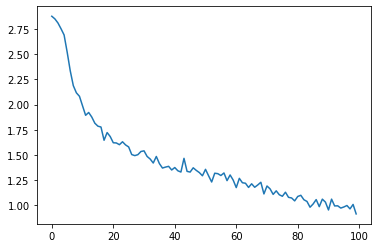

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


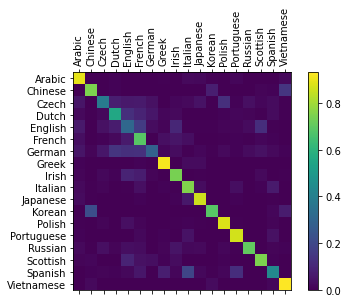

In [8]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [10]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.57) Russian
(-1.57) English
(-1.70) Czech

> Jackson
(-0.01) Scottish
(-4.40) English
(-6.67) Russian

> Satoshi
(-0.16) Italian
(-2.17) Japanese
(-4.11) Arabic
